# Point processes

This notebook is mainly based off the [MatthewDaws/PointProcesses](https://github.com/MatthewDaws/PointProcesses) GitHub repo.

## Notebook 1: Point processes

In [22]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils


def add_point(points, scale = 2.0):
    wait_time = np.random.exponential(scale)
    if len(points) == 0:
        last = 0
    else:
        last = points[-1]
    points.append(last + wait_time)
    

def sample_poisson_process(window_size = 100, scale = 2.0):
    points = []
    add_point(points, scale)
    while points[-1] < window_size:
        add_point(points, scale)
    return points

In [2]:
points = sample_poisson_process()
points[:5]

[0.8996781860254144,
 1.0304266153276813,
 4.127011046214319,
 5.239768146972313,
 8.377212215611749]

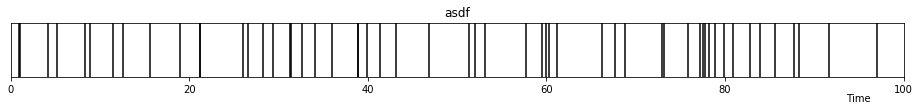

In [3]:
utils.plot_series(points, 'asdf')

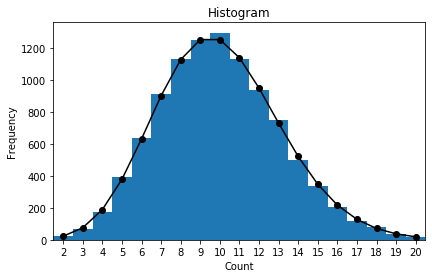

In [15]:
a, b = 20, 50
scale = 3.0
samples = 10000

counts = [
    sum(x >= a and x < b for x in sample_poisson_process(scale = scale))
    for _ in range(samples)]

expected = {x : scipy.stats.poisson.pmf(x, (b-a)/scale) for x in range(100)}

utils.histogram_with_expected(counts, expected, title = "Histogram")

Conditional on the number of events, each event is i.i.d. and uniformly distributed over the window size.

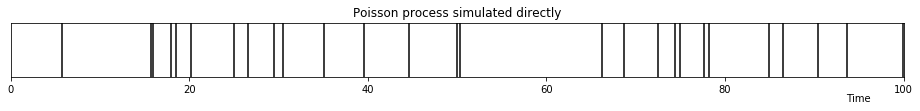

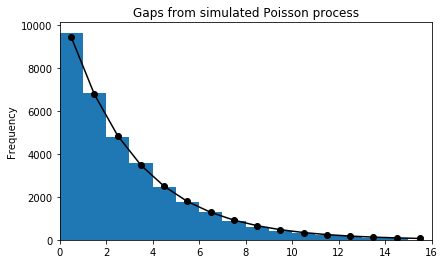

In [43]:
def sample_poisson_process_directly(window_size = 100, scale = 2.0):
    """Sample without need for creating points individually."""
    number_points = np.random.poisson(window_size/scale)
    points = np.random.uniform(low = 0, high = window_size, size = number_points)
    points.sort()
    return points

scale = 3.0
window_length = 100
points = sample_poisson_process_directly(window_length, scale)
utils.plot_series(points, "Poisson process simulated directly")

gaps = [y-x for x, y in zip(points[:-1], points[1:])]
last_point = points[-1]

for _ in range(1000):
    points = sample_poisson_process_directly(window_length, scale)
    gaps.append(points[0] - (last_point - window_length))
    gaps.extend(y-x for x,y in zip(points[:-1], points[1:]))
    
def exponential(a, b, scale):
    return scipy.stats.expon.cdf(b, scale = scale) - scipy.stats.expon.cdf(a, scale = scale)
    
expected = {x: exponential(x, x+1, scale) for x in range(20)}

utils.histogram_continuous(gaps, 1, expected, "Gaps from simulated Poisson process")


## Notebook 2: temporal point processes

In [125]:
def hawkes_intensity(points, t, mu, alpha):
    """Hawkes intensity function
    lambda = mu + alpha*sum(np.exp(-(t - s)) for set of points s <= t)
    """
    p = np.array(points)  # so we can use <=
    p = p[p<=t]
    p = alpha * np.exp(p-t)
    return mu + np.sum(p)

In [128]:
assert(np.isclose(1, hawkes_intensity([], 5, 1, 2)))
assert(np.isclose(2, hawkes_intensity([5], 5, 0, 2)))
assert(np.isclose(4, hawkes_intensity([4.9999999],5, 2,2)))
assert(np.isclose(2, hawkes_intensity([4.9999999, 8],5, 0, 2)))
assert(np.isclose(1, hawkes_intensity([5, 8],4, 1, 2)))

Use Otaga's modified thinning algorithm to simulate the Hawkes process. Accept if

$$
\lambda(t+s)/\lambda(t) >= Y
$$

where $Y \sim U(0,1)$.

In [129]:
def simulate_hawkes(window, mu, alpha):
    thinned_points = []
    all_points = []
    t = 0
    
    while t < window:
        l = hawkes_intensity(thinned_points, t, mu, alpha)
        wait_time = np.random.exponential(scale = 1/l)
        new_point = t+wait_time
        all_points.append(new_point)
        ratio = hawkes_intensity(thinned_points, new_point, mu, alpha) / l
        
        if ratio >= np.random.uniform():
            thinned_points.append(new_point)
        
        t = t + wait_time
        

    return thinned_points, all_points

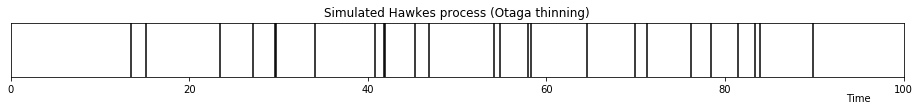

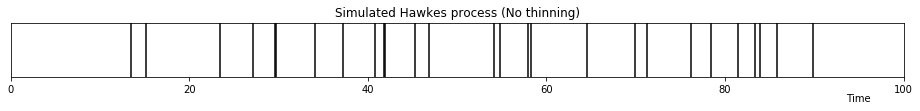

In [130]:
window = 100
mu = 0.2
alpha = 0.05

points, all_samples = simulate_hawkes(window, mu, alpha)

utils.plot_series(points, "Simulated Hawkes process (Otaga thinning)")
utils.plot_series(all_samples, "Simulated Hawkes process (No thinning)")

This code is just to plot the intensity function.

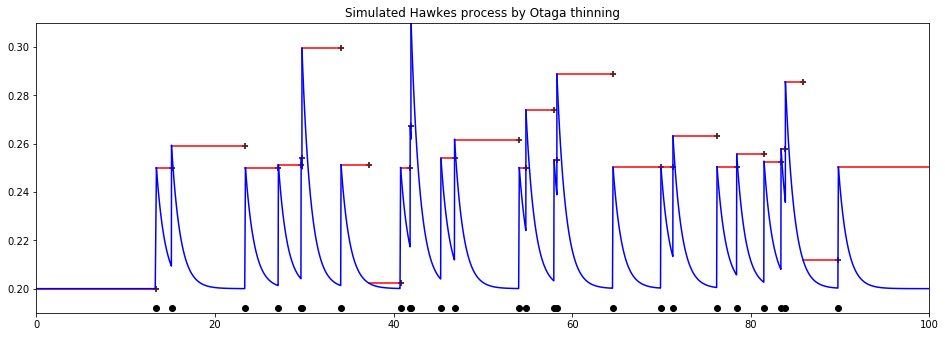

In [132]:
def add_intensity(ax, start, end, color):
    x = np.arange(101) / 100
    x = start + x * (end - start)
    y = [hawkes_intensity(points, t, mu, alpha) for t in x]
    ax.plot(x,y, color)

def add_homogeneous_intensity(ax, start, end, color):
    x = [start, end]
    y = hawkes_intensity(points, start, mu, alpha)
    y = [y, y]
    ax.plot(x,y, color)
    
width, _ = utils.slim_aspect()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, width/3))

ax.set(ylim=[0.19,0.31], xlim=[0,100])
ax.set(title="Simulated Hawkes process by Otaga thinning")

ax.scatter(points, [0.192 for _ in points], marker='o', color="black")

add_homogeneous_intensity(ax, 0, all_samples[0], "red")
for (s, e) in zip(all_samples[:-1], all_samples[1:]):
    add_homogeneous_intensity(ax, s, e, "red")

add_intensity(ax, 0, points[0], "blue")
for i in range(1, len(points)):
    add_intensity(ax, points[i-1], points[i], "blue")

y = [hawkes_intensity(points, t, mu, alpha) for t in [0] + all_samples[:-1]]
_ = ax.scatter(all_samples, y, marker="+", color="black")